## ISYE 6402, Module 4 - Bitcoin Price Forecasting

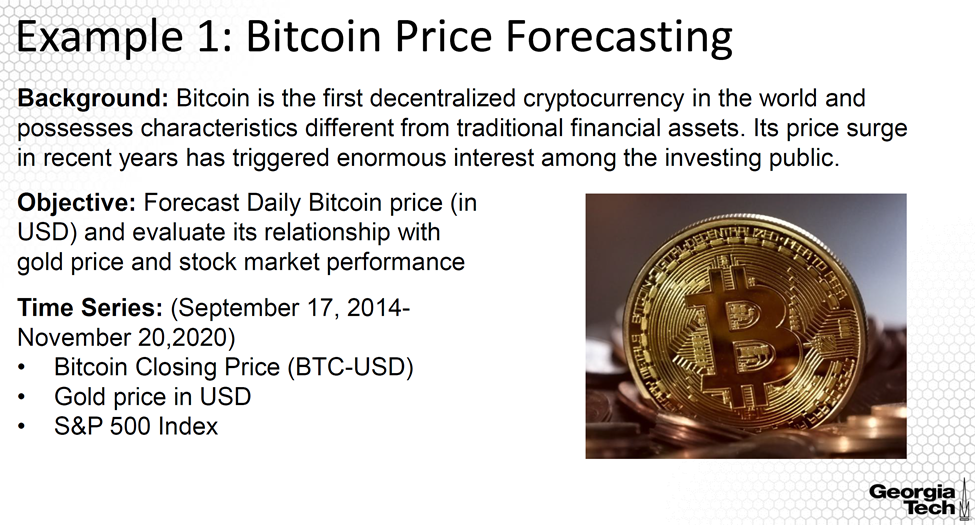

I'll begin illustrating the concept of multivariate time series with the analysis of the bitcoin price for the most recent years, particularly in relationship to the price of gold and the S&P 500 index. Correlation between bitcoin price and the other two financial instruments has been studied, with different insights and conclusions. Some studies pointed out that bitcoin and S&P 500 correlation is an indicator of market movement, with an increasing correlation between the two recently. Other studies have found that the relationship between bitcoin and S&P500 is stronger than ever, likely denting bitcoin’s appeal as digital gold. On the other hand, gold has maintained a strong track record of rallying in times of stress in the global equity markets, while bitcoin has yet to build a similar reputation as a safe-haven asset. All three financial instruments are now used as benchmarks for global stock markets.  In this example, we will analyze the relationships between the three time series over the period of time September 17, 2014 until November 20,2020.

In [1]:
library(xts, warn.conflicts = FALSE)
library(mgcv, warn.conflicts = FALSE)
library(data.table, warn.conflicts = FALSE)
library(vars, warn.conflicts = FALSE)
library(tseries, warn.conflicts = FALSE)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: nlme

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.

Loading required package: MASS

Loading required package: strucchange

Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
btc <- read.csv("btc.csv")
gold <- read.csv("gold.csv")
sp500 <- read.csv("sp500.csv")

In [3]:
head(btc, 3)
head(gold, 3)
head(sp500, 3)

,Date,Adj.Close
,<fct>,<dbl>
1,9/17/2014,457.334
2,9/18/2014,424.440
3,9/19/2014,394.796


,Date,Gold.Prices
,<fct>,<dbl>
1,9/17/2014,1236.5
2,9/18/2014,1223.0
3,9/19/2014,1222.5


,Date,Price
,<fct>,<dbl>
1,9/17/2014,2001.57
2,9/18/2014,2011.36
3,9/19/2014,2010.40


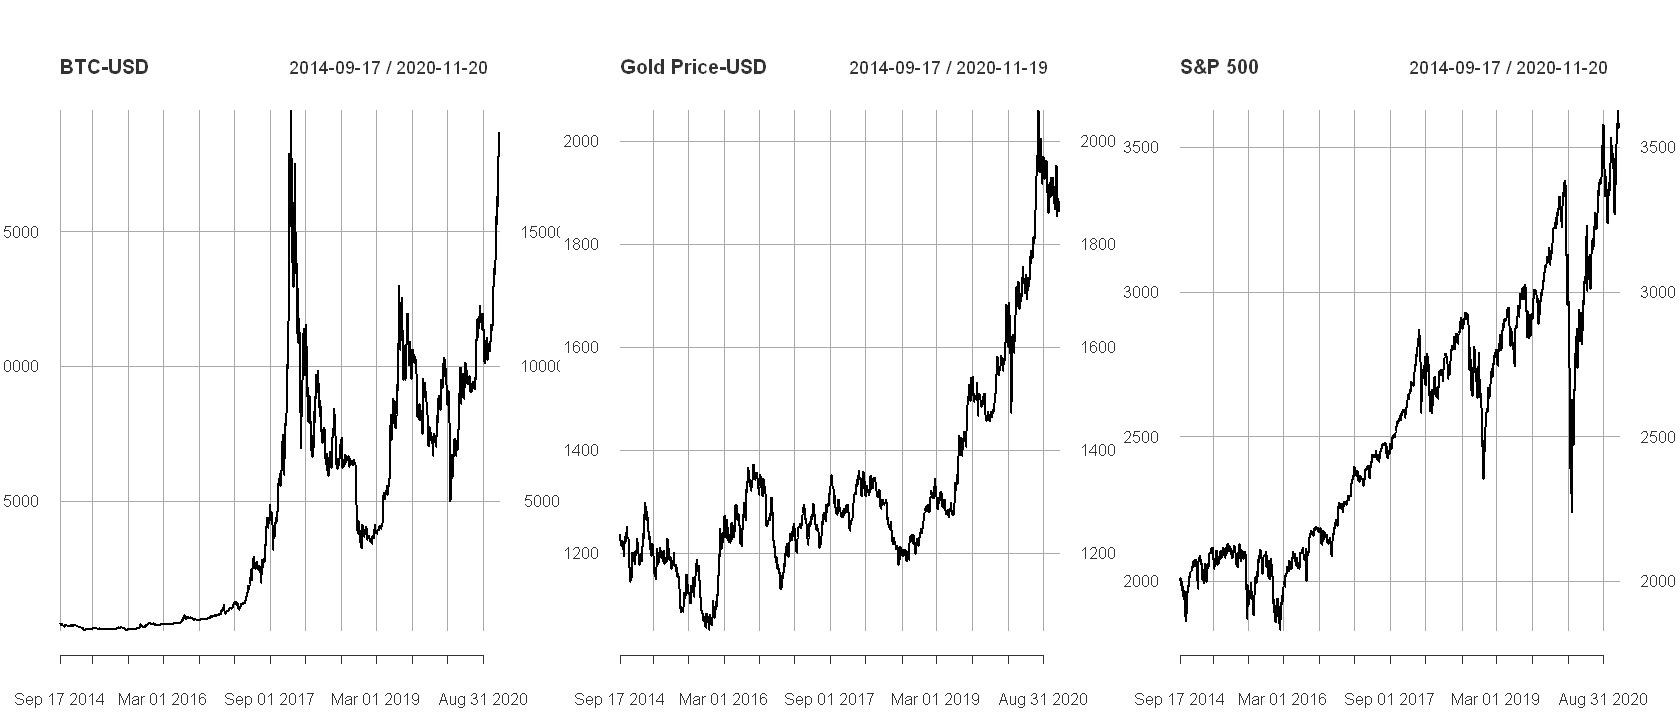

In [4]:
options(repr.plot.width=14, repr.plot.height=6)
par(mfrow=c(1,3))

pricebtc<-btc[,2]
datesbtc<-as.Date(btc[,1],"%m/%d/%Y")
tsbtc=xts(pricebtc,datesbtc)
dlbtc<-diff(log(tsbtc))
plot(tsbtc,main='BTC-USD')

pricegold<-gold[,2]
datesgold<-as.Date(gold[,1],"%m/%d/%Y")
tsgold<-xts(pricegold,datesgold)
dlgold<-diff(log(tsgold))
plot(tsgold,main='Gold Price-USD')

pricesp<-sp500[,2]
datessp<-as.Date(sp500[,1],"%m/%d/%Y")
tssp<-xts(pricesp,datessp)
dlsp<-diff(log(tssp))
plot(tssp,main='S&P 500')

These are the time series of the three financial instruments. 
- Bitcoin behaves more like a highly leveraged position and follows the market trends in a more volatile, dramatic up and down swings as compared to the gold price, which has had a steady increase over the past six years. 
- S&P500 behaves a bit more like the bitcoin price, with up and down swings although with smaller volatility.

Using multivariate analysis, we will assess the lead and lag dependencies between these three time series? 

Which of the three time series leads in changing up or down?

Can we predict any of the three time series better if accounting for the relationships with the other two time series? 

To address these questions, we will need to employ multivariate time series modeling.

**Return Price Time Series Analysis**

When I introduced this data example, I presented the time series plots of the three time series. Now we are taking the first order difference of the log price of bitcoin, gold and SP500 providing the return price time series then compare the plots of the return price time series.

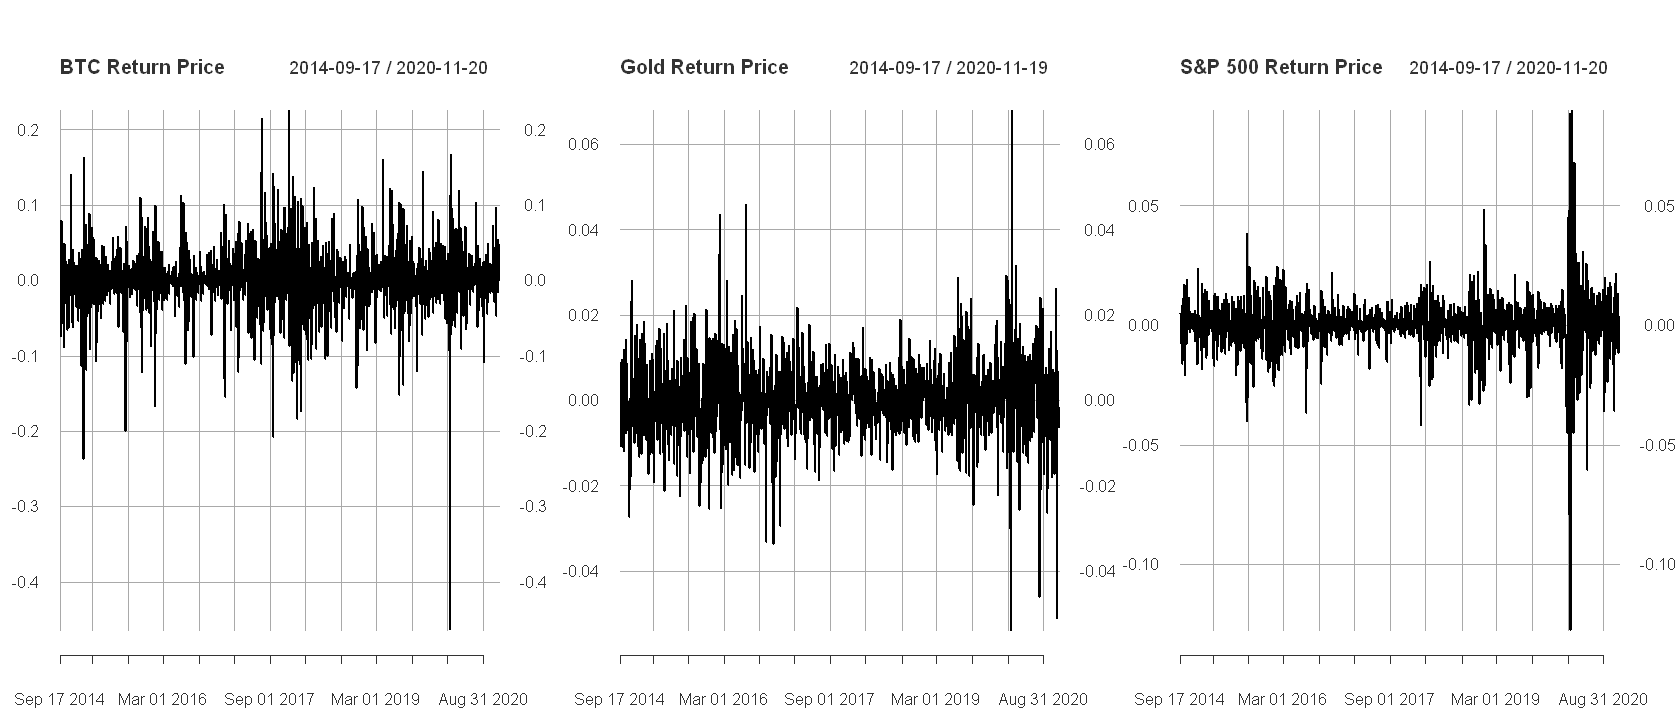

In [5]:
par(mfrow=c(1,3))

plot(dlbtc,main='BTC Return Price')
plot(dlgold,main='Gold Return Price')
plot(dlsp,main='S&P 500 Return Price')

As expected, there is very large volatility at the beginning of the pandemic in March 2020, the highest volatility since 2014. The volatility is present across all three financial instruments. 

However, we can identify other periods of large volatility for the return price of the bitcoin but not for gold or SP500. Generally, it is challenging to identify any possible contemporaneous or lead-lag relationships between the three time series based on these plots alone.

**Return Price Analysis**

- Next, we will evaluate stationarity and the dependence within and between the three time series. 
- The first set of R commands are applying the **Augmented Dickey-Fuller test for stationarity**. 
- For this test, the **null hypothesis is that the time series is not stationary vs the alternative that it is stationary**.

In [6]:
dlbtc <- dlbtc[-1]
dlgold <- dlgold[-1]
dlsp <- dlsp[-1]

## Augmented Dickey-Fuller test for stationarity (H0: not stationary vs HA: stationary)
adf.test(dlbtc)
adf.test(dlgold)
adf.test(dlsp)

Warning message in adf.test(dlbtc):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  dlbtc
Dickey-Fuller = -12.214, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(dlgold):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  dlgold
Dickey-Fuller = -11.462, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(dlsp):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  dlsp
Dickey-Fuller = -10.805, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


Applying the ADF test, we obtain p-values smaller than 0.1 for all three time series, rejecting the null hypothesis, hence concluding that the time series are stationary.

**Merging Time Series**

- Next, I merged all three time series into a multivariate time series using the merge command.
- Note that the three time series are not observed exactly at the same dates. 
- Particularly the bitcoin price is recorded for weekdays as well as weekends; the bitcoin price is also recorded over holidays and other dates when the gold and SP500 prices are not recorded since they are not traded.
- The merge() command allows to merge the time series only for the dates for which the time series are both observed. 
- Hence, it is important to first merge the three time series into a multivariate time series before analyzing the relationship between them. 
- Last I applied the acf() command to obtain the auto-correlation and cross-correlation plots for the multivariate time series.
- The acf() command applies to univariate as well as multivariate time series.

**Auto & Cross Dependence**

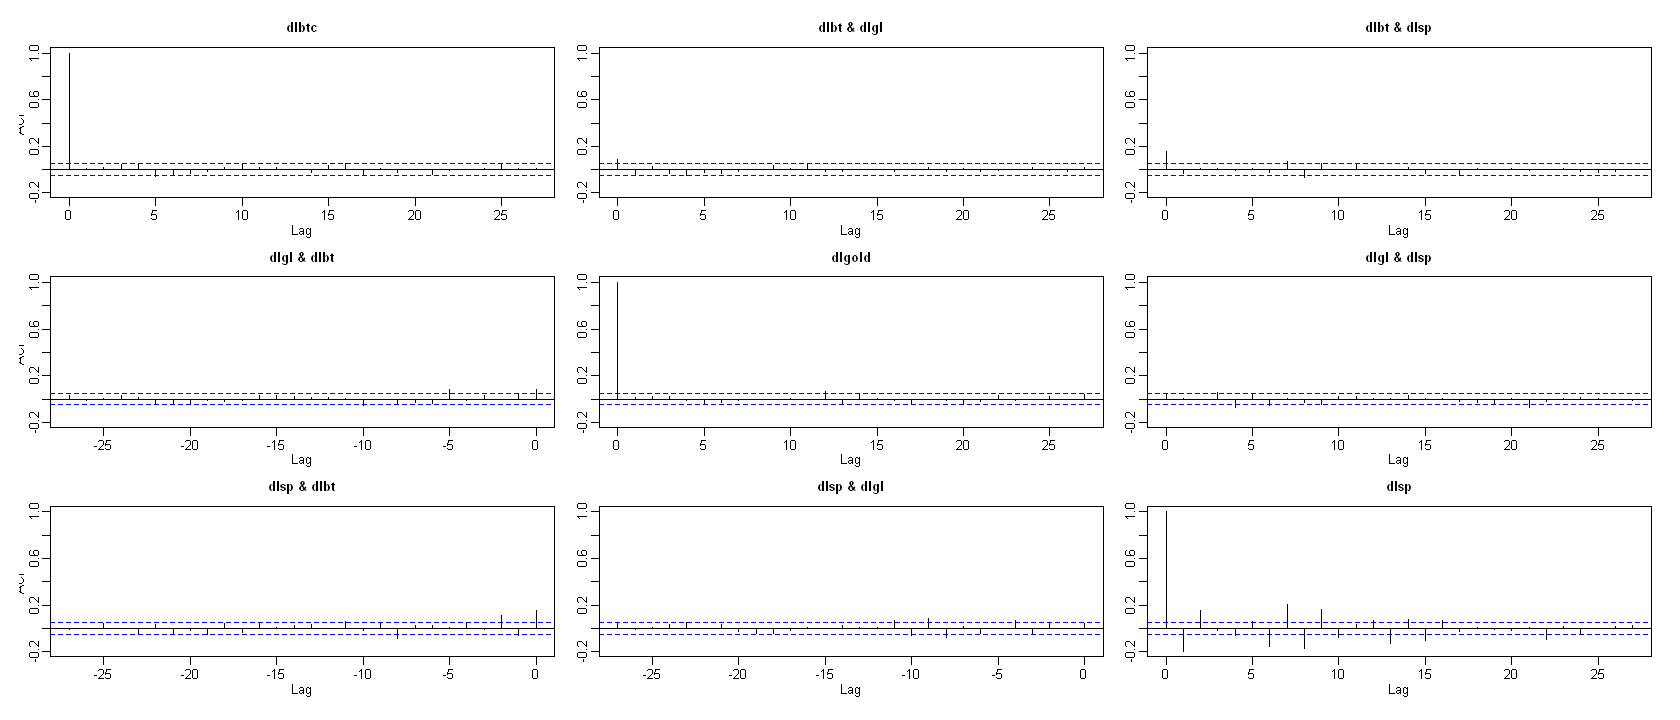

In [7]:
## ACF Analysis for all three time series together
ts.merge <- merge(tsbtc,tsgold, join='inner')
ts.merge <- merge(ts.merge,tssp, join='inner')
colnames(ts.merge)<-c("tsbtc","tsgold","tssp")

dl.merge <- merge(dlbtc,dlgold, join='inner')
dl.merge <- merge(dl.merge,dlsp, join='inner')
colnames(dl.merge)<-c("dlbtc","dlgold","dlsp")
acf(dl.merge)

The resulting plots from applying the acf() command to a multivariate time series are on the slide. 

- The auto-correlation plots are on the diagonal and the cross-correlation plots are off the diagonal. 
- The auto-correlation plots on the diagonal resemble the acf plot of a white noise, with no significant auto-correlation values for lags larger than 0. 
- The cross-correlation plots off the diagonal are for each pair of time series capturing the lead and lag relationships for each pair. 

Recall that in the previous lesson, I mentioned that **the lag correlation between any pair of time series is not symmetric**. That is, it depends on which time series in the pair is the lead and which one is the lag time series. You can identify which time series is the lead or the lag from the sub-title; **the first time series in the sub-title is the lag time series**.

For example, the correlation plots in the first row include: 
- the auto-correlation plot for the return price for bitcoin, 
- the cross-correlation plot for the return price for bitcoin and for gold, and 
- the cross-correlation plot for the return price for bitcoin and for SP500, 
displaying the cross-correlation in which the return price for bitcoin is the lag time series. 

This means that these plots **display the auto-correlation values for the bitcoin at time t and for gold or SP500 at time t-k for varying values of k**. The first bar in these plots corresponds to the **contemporaneous correlation**, that is the correlation return price for **bitcoin and that of gold or SP500 both at the same time t**.

We also have the cross-correlation plots displaying the **cross-correlation in which the return price for bitcoin is the lead time series. That is, these plots present the estimated cross-correlation for the bitcoin at time t-k and for gold or SP500 at time t for varying values of k**. 

- Note that these plots show the cross-correlation with the lags provided in reverse order. The last bar in these plots corresponds to the contemporaneous correlation, that is, the correlation return price for bitcoin and that of gold or SP500 both at the same time t. 
- The last bar in these plots will be the same as the first bar for the plots in the first row. 

How can we interpret the lead-lag correlation from these plots? 
- The auto-correlation plots resemble those of white noise.
- The contemporaneous and cross correlation have not statistically significant values, that is, within the confidence bands, indicating that the bitcoin price may not be neither led or lagged by the return price of gold or SP500.

**Correlation Analysis**

- Next I performed a correlation analysis for the price (not the return) time series of the bitcoin, gold and SP500. 
- To compute the contemporaneous correlation, we can use the cor() command applied to the merged time series. 
- This command will provide a 3 by 3 matrix of correlation values.

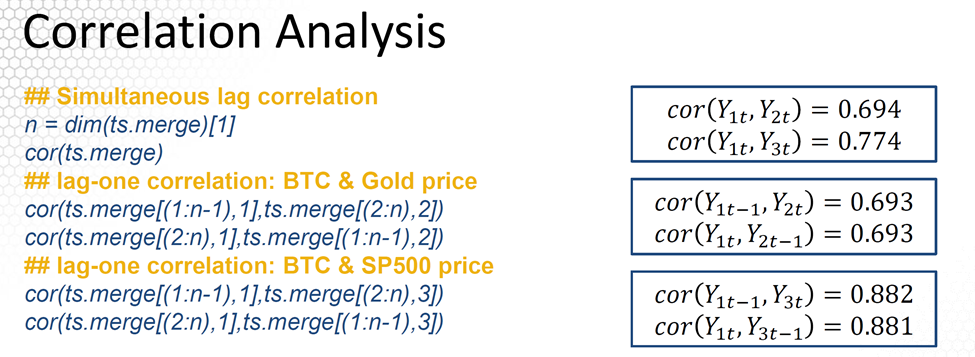

In [8]:
cor(ts.merge)

,tsbtc,tsgold,tssp
tsbtc,1.0000000,0.6942657,0.8828305
tsgold,0.6942657,1.0000000,0.7740792
tssp,0.8828305,0.7740792,1.0000000


Those of interest are the correlation values between bitcoin price and the gold price, which is 0.694, and between bitcoin price and the SP500 price, which is 0.883

In [9]:
n <- dim(ts.merge)[1]

## lag-one and lead correlation between BTC & Gold price
cor(ts.merge[(1:n-1),1],ts.merge[(2:n),2])
cor(ts.merge[(2:n),1],ts.merge[(1:n-1),2])

## lag-one and lead correlation between BTC & SP500 price
cor(ts.merge[(1:n-1),1],ts.merge[(2:n),3])
cor(ts.merge[(2:n),1],ts.merge[(1:n-1),3])

,tsgold
tsbtc,0.6930171


,tsgold
tsbtc,0.6934686


,tssp
tsbtc,0.8824968


,tssp
tsbtc,0.8818452


We can also compute the **lead and lag correlations** of the bitcoin price with the gold price. The lead correlation is 0.693 and the lag correlation is the same.

Last, we can compute those correlations values for bitcoin price with the SP500 price. The lead and lag correlations are higher than the contemporaneous correlation and they are approximately 0.882

**Correlation Analysis: Return Time Series**

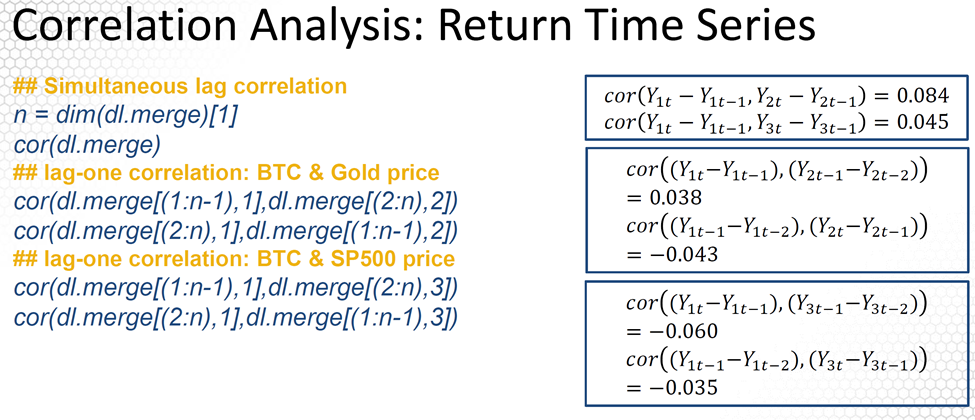

In [10]:
n <- dim(dl.merge)[1]
cor(dl.merge)

,dlbtc,dlgold,dlsp
dlbtc,1.00000000,0.08412891,0.1549309
dlgold,0.08412891,1.00000000,0.0450944
dlsp,0.15493092,0.04509440,1.0000000


In [11]:
## lag-one correlation between BTC & Gold price
cor(dl.merge[(1:n-1),1],dl.merge[(2:n),2])
cor(dl.merge[(2:n),1],dl.merge[(1:n-1),2])
## lag-one correlation between BTC & SP500 price
cor(dl.merge[(1:n-1),1],dl.merge[(2:n),3])
cor(dl.merge[(2:n),1],dl.merge[(1:n-1),3])

,dlgold
dlbtc,0.03874635


,dlgold
dlbtc,-0.04366737


,dlsp
dlbtc,-0.06034275


,dlsp
dlbtc,-0.03556839


Last, we can evaluate the contemporaneous and lead-lag correlations for the return price of the three financial instruments. The contemporaneous correlation for the bitcoin-gold pair is 0.084 and for the bitcoin-SP500 pair is 0.045, hence both close to 0 indicating little cross correlation.

Similarly, the lead-lag correlation for the bitcoin-gold pair and for the Bitcoin-SP5000 pair are close to zero.

**Univariate AR vs VAR: Order Selection**

In [12]:
## Univariate AR vs VAR: Order Selection

## Select AR Order
mod_btc = ar(dlbtc,order.max=20)
print(mod_btc$order)

mod_gold = ar(dlgold,order.max=20)
print(mod_gold$order)

mod_sp = ar(dlsp,order.max=20)
print(mod_sp$order)

[1] 0
[1] 0
[1] 9


- We will first apply the simple AR model to each individual time series and select the order of AR for each time series.
- Setting up 20 to be the maximum order, the selected AR order for the bitcoin return price and for the gold return price is 0 and for S&P500 return price is 9. 
- This says that the return price for bitcoin and gold behaves like white noise where that for S&P500 has some serial correlation to be modeled. 

**This is an interesting finding saying that the mean change in price for bitcoin does not depend on the past return price.**

In [13]:
## Capture relationship of change 
mod_aic_1 = VAR(dl.merge,lag.max=20,ic="AIC", type="const")
mod_aic_2 = VAR(dl.merge,lag.max=20,ic="AIC", type="trend")
mod_aic_3 = VAR(dl.merge,lag.max=20,ic="AIC", type="both")

pord_1 = mod_aic_1$p; pord_2 = mod_aic_2$p; pord_3 = mod_aic_3$p

pord_1
pord_2
pord_3

AIC(n) 
     9

AIC(n) 
     9

AIC(n) 
     9

In [14]:
mod_hq = VAR(dl.merge,lag.max=20,ic="HQ")
mod_sc = VAR(dl.merge,lag.max=20,ic="SC")
mod_fpe = VAR(dl.merge,lag.max=20,ic="FPE")

pord_hq = mod_hq$p; pord_sc = mod_sc$p; pord_fpe = mod_fpe$p

pord_hq
pord_sc
pord_fpe

HQ(n) 
    2

SC(n) 
    1

FPE(n) 
     9

But we are also interested to capture the temporal relationship between the three time series, hence we apply the VAR model in R. 

- The input for this R function is data consisting of the multivariate trivariate time series, 
- the maximum lag for model fit and the specification of whether to fit a trend, 
- a constant accounting for the non-zero mean in the time series, none or both, as compared in the three R lines of code.

Note the VAR() command also selects the order hence the specification of the maximum lag to be considered. These are variations of implementation of the VAR() command with different types of deterministic trend along with the information criterion for model selection to be AIC. The selected order for this model implementation is 9, which is the largest AR order among the AR model applied to each of the three time series.

Further I applied other model selection approaches, for example HQ and SC are similar to BIC, generally penalizing more for model complexity than AIC hence selecting lower order models. The HQ criterion selects an order 2 VAR model, for example.

**VAR Model: Unrestricted vs Restricted**

- We will continue with the VAR model with order 2.
- The VAR() command provides the unrestricted model where the restrict() command drops the coefficients based on the their statistical significance hence providing a restricted VAR model. 
- We do know however that this is not a correct approach for dropping coefficients based on their contribution to model significance;
- it would be more appropriate to apply a variable selection approach such as stepwise regression or penalized lasso regression to each individual time series to restrict the model.

In [15]:
## Apply VAR Model ####

## Divide data into test & train 
dl.train <- dl.merge[1:(n-30),]
dl.test <-  dl.merge[(n-29):n,]

# Model Fitting: Unrestricted VAR
#model.var <- VAR(dl.merge,p=2)
model.var <- VAR(dl.train,p=2)
summary(model.var)


VAR Estimation Results:
Endogenous variables: dlbtc, dlgold, dlsp 
Deterministic variables: const 
Sample size: 1508 
Log Likelihood: 12302.81 
Roots of the characteristic polynomial:
0.4298 0.2353 0.2353 0.1766 0.08313 0.07792
Call:
VAR(y = dl.train, p = 2)


Estimation results for equation dlbtc: 
dlbtc = dlbtc.l1 + dlgold.l1 + dlsp.l1 + dlbtc.l2 + dlgold.l2 + dlsp.l2 + const 

           Estimate Std. Error t value Pr(>|t|)  
dlbtc.l1   0.014648   0.026133   0.561   0.5752  
dlgold.l1 -0.225668   0.123935  -1.821   0.0688 .
dlsp.l1   -0.139541   0.094928  -1.470   0.1418  
dlbtc.l2   0.011202   0.026112   0.429   0.6680  
dlgold.l2  0.134049   0.123952   1.081   0.2797  
dlsp.l2    0.005169   0.094868   0.054   0.9566  
const      0.001860   0.001079   1.724   0.0849 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.04177 on 1501 degrees of freedom
Multiple R-Squared: 0.004755,	Adjusted R-squared: 0.0007771 
F-statistic: 1.195 on 6 an

**Estimated Coefficients: Bitcoin**

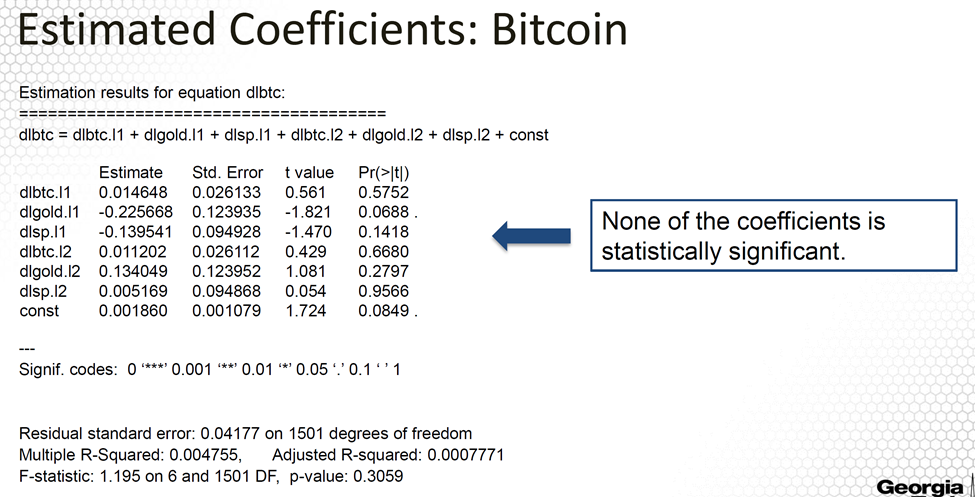


Let’s review the model output from the VAR() model implementation. 
- Each of the three time series will have an output as the one provided on the slide for the Bitcoin price return. 
- The output consists of the estimates, their standard error and the p-values for statistical inference for all six factors corresponding to lags 1 and 2 of all three time series. 

From the output, none of the coefficients is statistically significant because all p-values are large. 

**This suggests that there is no lead relationship of the gold and S&P500 return price. That is, changes in those two return prices will not explain future changes in the bitcoin price.**

**Estimated Coefficients: SP500**

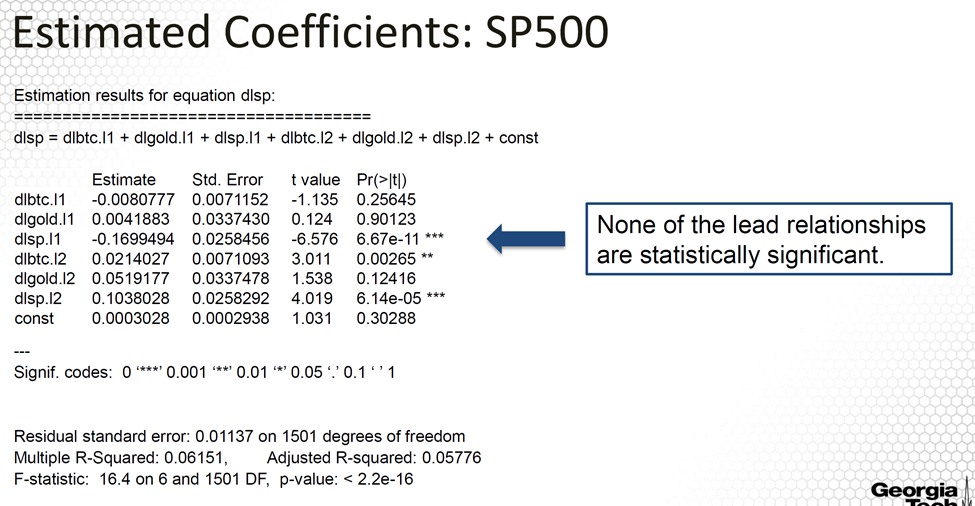


I am skipping the output for the gold return price and show here the output for the S&P500 return price. The output looks similar to that of the bitcoin return price since we have the same set of factors in the model. However the estimates are different.  

From the output, none of the lead relationships of the bitcoin and gold returns are statistically significant. However, we see that the factors corresponding to lags of S&P500 are statistically significant. Together with the results from the previous slide, we learn that there is no lead-lag relationship between bitcoin and SP500 price returns.

In [34]:
#Model Fitting: Restricted VAR        
model.var.restrict <- restrict(model.var)
summary(model.var.restrict)

ERROR: Error in restrict(model.var): 
No significant regressors remaining in equation for dlbtc .



**VAR: Residual Analysis**

Next let’s perform a residual analysis to evaluate whether the residuals have constant variance, are normally distributed and whether they are uncorrelated.

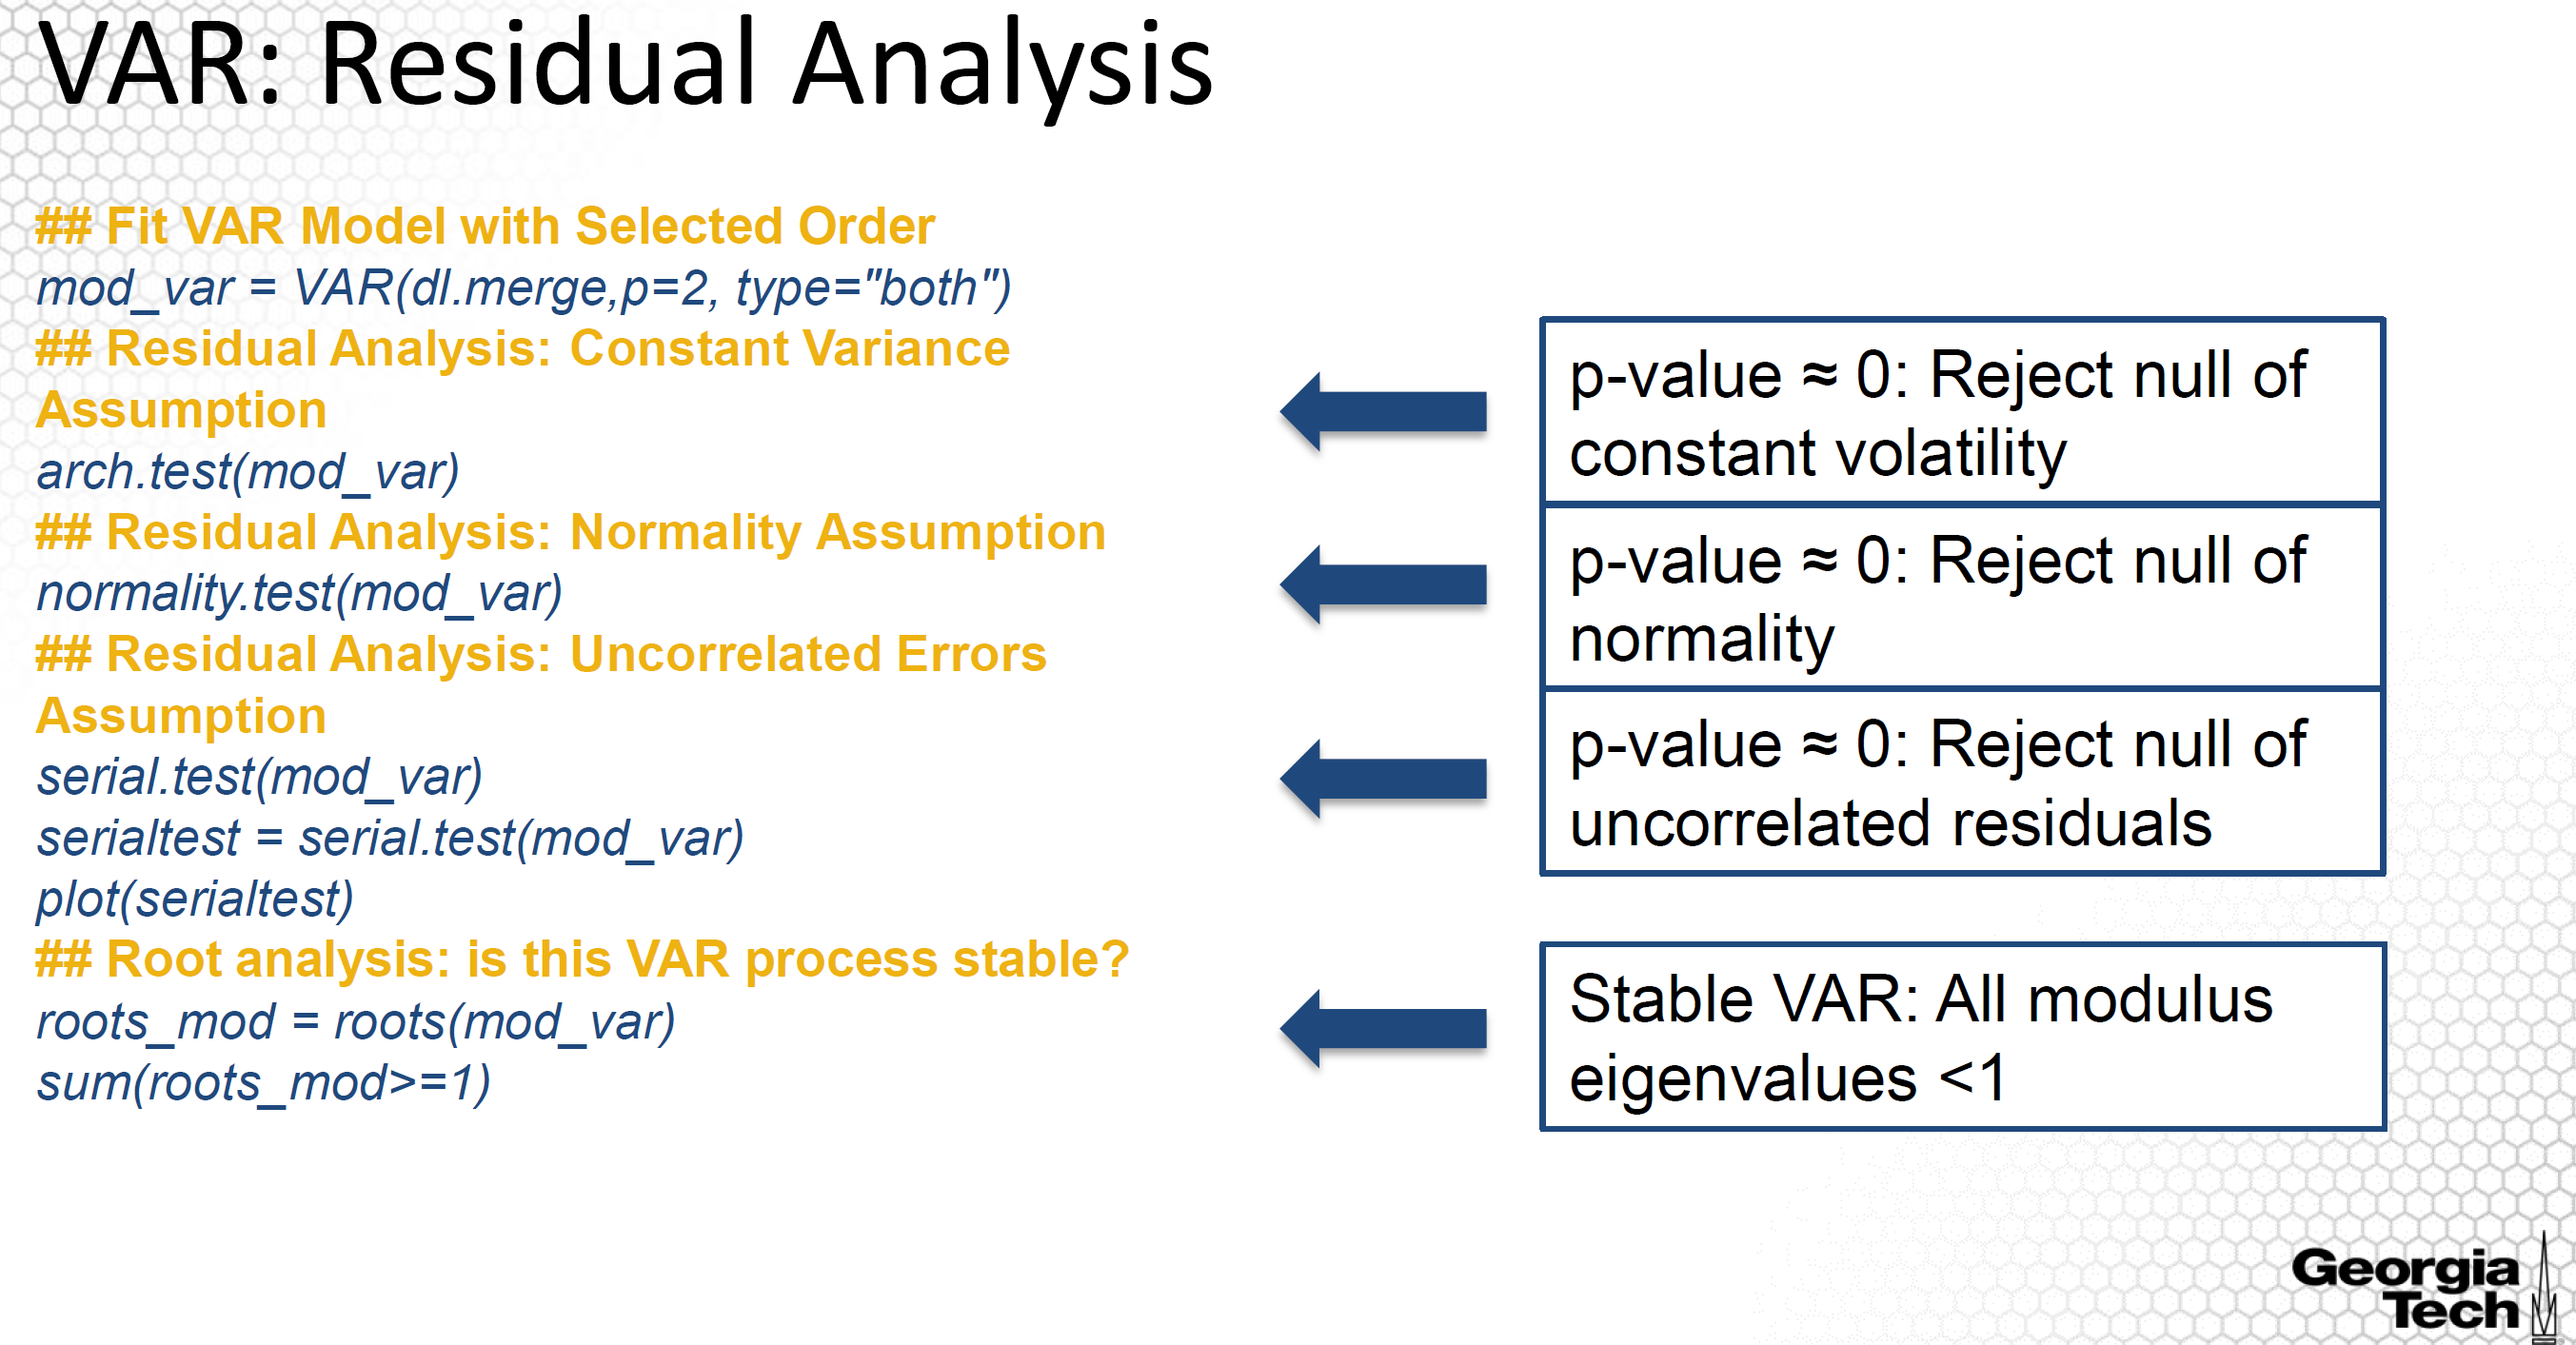

**Residual Analysis: Constant Variance Assumption**

In [17]:
arch.test(model.var)


	ARCH (multivariate)

data:  Residuals of VAR object model.var
Chi-squared = 2064.2, df = 180, p-value < 2.2e-16

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object model.var
Chi-squared = 2064.2, df = 180, p-value < 2.2e-16



- The arch.test() is used to evaluate whether the residuals have constant variance. 
- Since the p-value is approximately zero, we reject the null hypothesis of constant variance.

**Residual Analysis: Normality Assumption**

In [18]:
normality.test(model.var)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object model.var
Chi-squared = 25623, df = 6, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object model.var
Chi-squared = 520.67, df = 3, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object model.var
Chi-squared = 25102, df = 3, p-value < 2.2e-16


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object model.var
Chi-squared = 25623, df = 6, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object model.var
Chi-squared = 520.67, df = 3, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object model.var
Chi-squared = 25102, df = 3, p-value < 2.2e-16




- The normality.test() is used to evaluate whether the residuals are normally distributed.  
- Since the p-value is approximately zero, we reject the null hypothesis of normality. 
- Note that we do not to assume normality in VAR. We need normality if we want to use the t-test for statistical significance.
- If normality does not hold, we can instead use an approximate normal test assuming large sample size or large number of time points.

**Residual Analysis: Uncorrelated Errors Assumption**


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object model.var
Chi-squared = 287.1, df = 126, p-value = 1.366e-14

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object model.var
Chi-squared = 287.1, df = 126, p-value = 1.366e-14



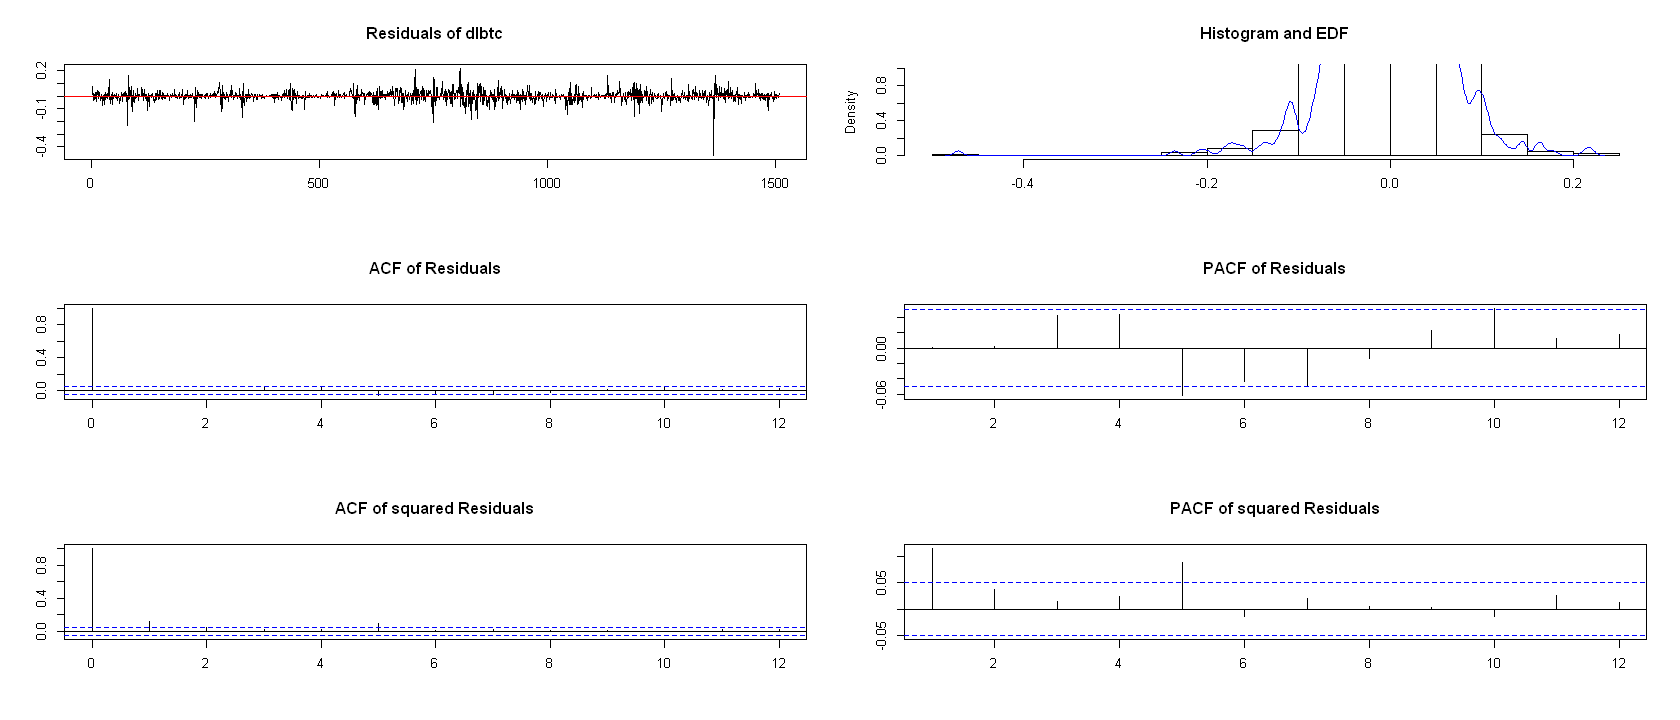

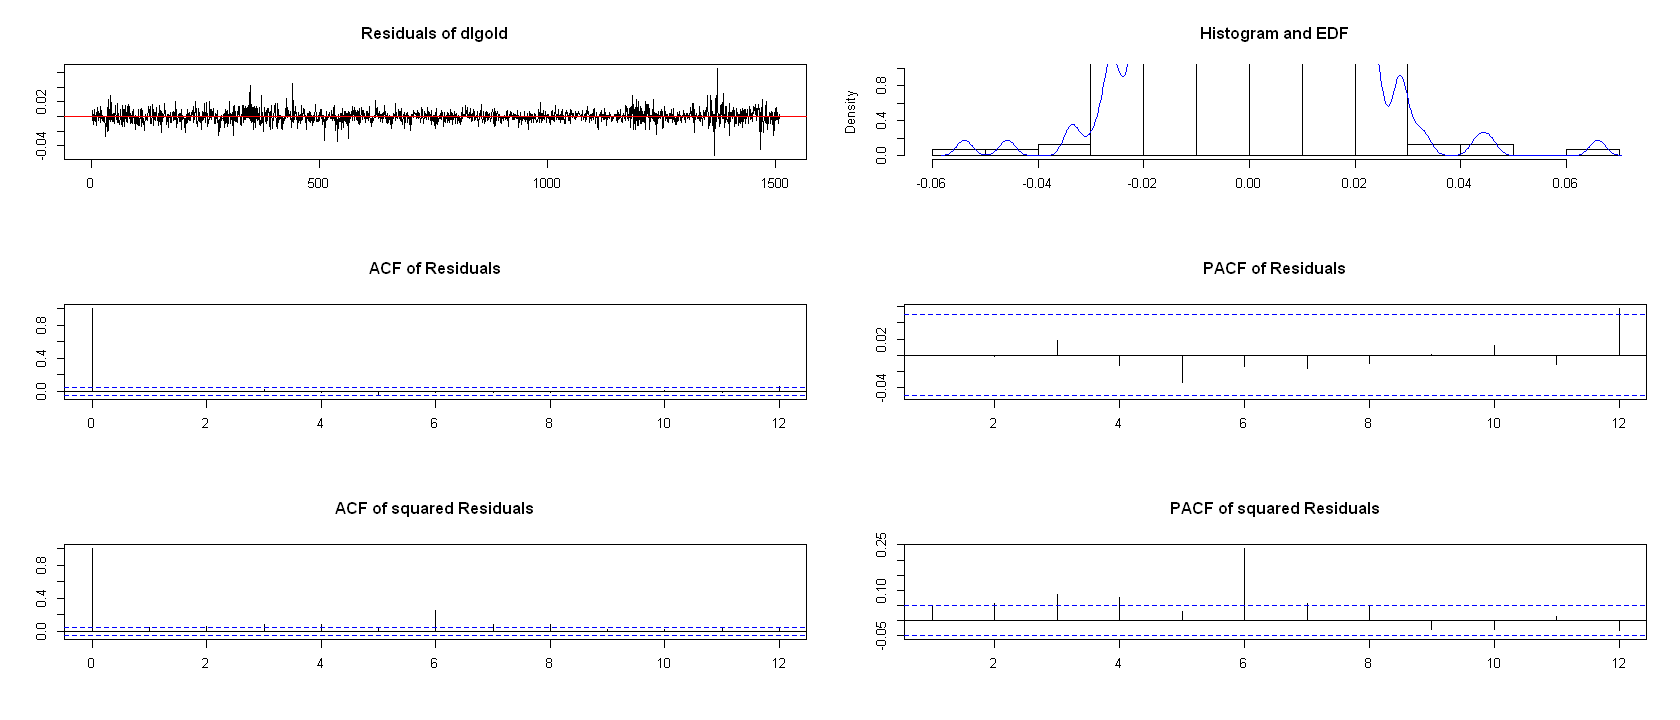

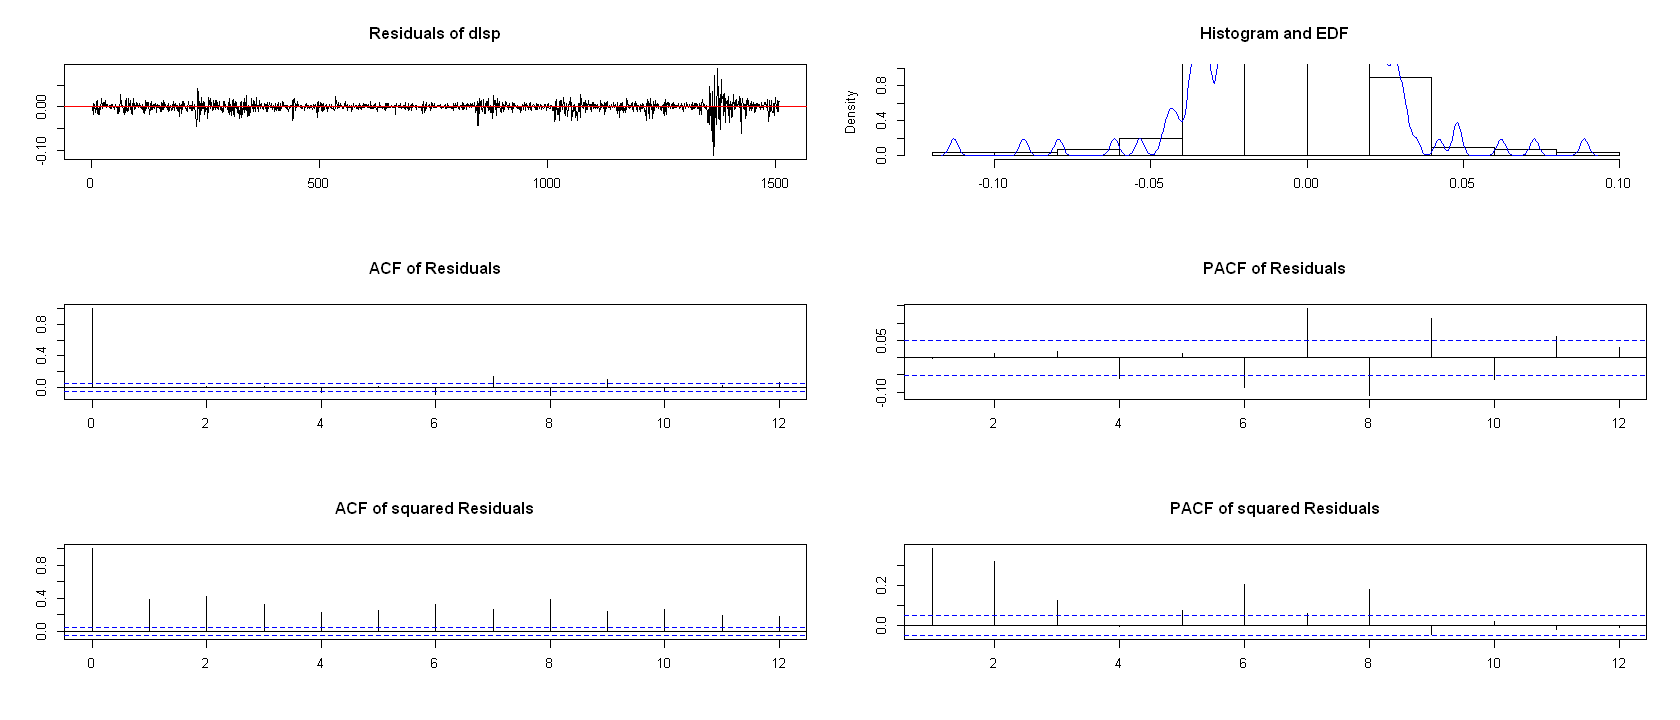

In [19]:
serialtest = serial.test(model.var)
serialtest
plot(serialtest)

- The serial.test() is used to evaluate whether the residuals are uncorrelated. 
- Since the p-value is approximately zero, we reject the null hypothesis of uncorrelated residuals

Next let’s look at the residual plots to explore further the non-constant variance and the non-normality of the residuals. 

From the residual plots for the time series corresponding to the bitcoin price return:
- The upper left plot is the residual plot, clearly showing non-constant variance.
- The upper right plot is the histogram of the residuals. From this plot, we see that the distribution of the residuals is somewhere symmetric but with heavy tails hence the rejection of the normality. 
- The rest of the plots are the auto-correlation plot of the residuals and of the squared residuals. These plots indicate that the residuals and the squared residuals are uncorrelated.

**Root analysis: is this VAR process stable?**

In [20]:
roots_mod = roots(model.var)
roots_mod
sum(roots_mod >= 1)

[1] 0.42979488 0.23532531 0.23532531 0.17662560 0.08312576 0.07792090

[1] 0

- Last, we assess the property of stability. 
- All eigenvalues of the companion matrix are smaller than 1 and thus the fitted VAR is stable. 

**Testing for Granger Causality**

In [21]:
# Granger Causality Tests

## Estimated coefficients and their variance for Bitcoin regression Equaltion
coef.btc = coefficients(model.var)$dlbtc[-(2*3+1),1]
var.btc = vcov(model.var)[c(2:(2*3+1)),c(2:(2*3+1))]

## Estimated coefficients and their variance for SP500 regression Equaltion
coef.sp = coefficients(model.var)$dlsp[-(2*3+1),1]
sp.index = c(16:21)
var.sp = vcov(model.var)[sp.index,sp.index]

- We can test whether there is Granger causality between Bitcoin and S&P500 price returns using the Wald test as presented in previous slides. 
- On this slide, I am providing the R lines of code to extract the coefficients corresponding to the bitcoin price regression equation; for this we consider the regression equation for the dlbtc, where the first column gives us the estimates while we discard the last coefficient corresponding to the constant. 
- In the next line, we extract the covariance matrix of the corresponding coefficients. 
- We apply a similar procedure for the coefficients corresponding to the  S&P500 regression equation. 
- Be careful when you extract the covariance matrix corresponding to the coefficients of interest. 
- The rows & columns in the covariance matrix need to correspond exactly to the coefficients that need to be considered for the testing procedure, in this case, we are interested in the coefficients for bitcoin and S&P500 only.

In [22]:
library(aod, warn.conflicts = FALSE)

# Is there a lead-lag relationship for btc-sp500
wald.test(b=coef.btc, var.btc,Terms = c(3,6))
wald.test(b=coef.sp, var.sp,Terms = c(1,4))

Wald test:
----------

Chi-squared test:
X2 = 2.3, df = 2, P(> X2) = 0.32

Wald test:
----------

Chi-squared test:
X2 = 10.2, df = 2, P(> X2) = 0.006

- Next, I am applying the Wald test in the ‘aod’ library.
- For the first test, I am considering testing the coefficients corresponding to S&P500 in the Bitcoin regression equation which are given by the Terms 3 & 6 in the vector of coefficients for the Bitcoin regression equation. 
- Using the notation for the VAR model provided in one of the previous lessons, we are testing whether the coefficients  Pi_(1,3) for lags 1 and 2. 
- The p-value for this test is 0.32, meaning that **we don’t reject the null hypothesis that both coefficients are zero and interpreting that changes in SP500 plausibly do not influence changes in Bitcoin, that is, changes in S&P500 fail to lead changes in Bitcoin price**.


Similarly, we can apply the Wald test on the coefficients corresponding to S&P500 to learn whether Bitcoin may lead S&P500.

- For this we apply the Wald test to the coefficients corresponding to the S&P500 equation focusing only on those coefficients corresponding to lags 1 & 2 of the Bitcoin price return, terms 1 and 4 in the vector of the coefficients. 
- Those coefficients correspond to Pi_31.
- The p-value of this test is 0.006, **meaning that we reject the null hypothesis and interpreting that changes in Bitcoin price explain changes in S&P500, that is, the Bitcoin price return Granger cause the S&P500 price return**.


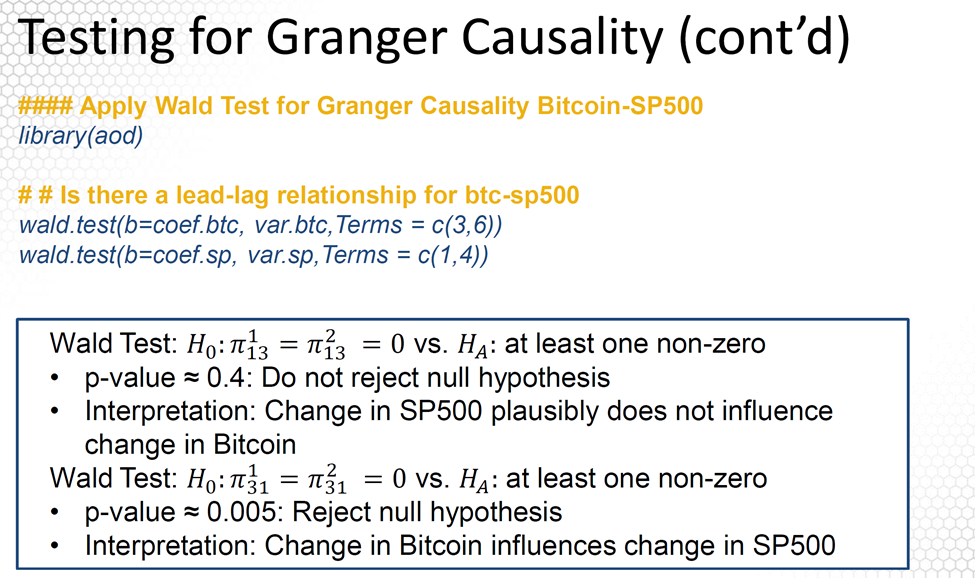

**Evaluating Cointegration**

In [23]:
## Evaluate potential cointegration visually

# Consider log transformed time series
lbtc<- log(pricebtc)
tsbtc<-xts(lbtc,datesbtc)

lsp <- log(pricesp)
tssp<-xts(lsp,datessp)

lgold<- log(pricegold)
tsgold<-xts(lgold,datesgold)

In [24]:
#Apply Linear Regression & Rescale SP500 Price

ts.merge <- merge(tsbtc,tssp, join='inner')
lm.btcsp <- lm(ts.merge[,1]~ts.merge[,2])
summary(lm.btcsp)

coef.sp <-lm.btcsp$coef
tr.tssp<-xts((coef.sp[2]*lsp+coef.sp[1]),datessp)


Call:
lm(formula = ts.merge[, 1] ~ ts.merge[, 2])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1818 -0.3397 -0.0408  0.3479  1.9655 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -54.26462    0.62100  -87.38   <2e-16 ***
ts.merge[, 2]   7.91718    0.07936   99.76   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5361 on 1556 degrees of freedom
Multiple R-squared:  0.8648,	Adjusted R-squared:  0.8647 
F-statistic:  9952 on 1 and 1556 DF,  p-value: < 2.2e-16


In [25]:
#Apply Linear Regression & Rescale Gold Price

ts.merge <- merge(tsbtc,tsgold, join='inner')
lm.btcgold <- lm(ts.merge[,1]~ts.merge[,2])
summary(lm.btcgold)

coef.gold <-lm.btcgold$coef
tr.tsgold<-xts((coef.gold[2]*lgold+coef.gold[1]),datesgold)


Call:
lm(formula = ts.merge[, 1] ~ ts.merge[, 2])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1558 -1.0594 -0.1838  0.9212  2.5290 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -41.4490     1.4180  -29.23   <2e-16 ***
ts.merge[, 2]   6.8338     0.1973   34.64   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.098 on 1576 degrees of freedom
Multiple R-squared:  0.4322,	Adjusted R-squared:  0.4319 
F-statistic:  1200 on 1 and 1576 DF,  p-value: < 2.2e-16


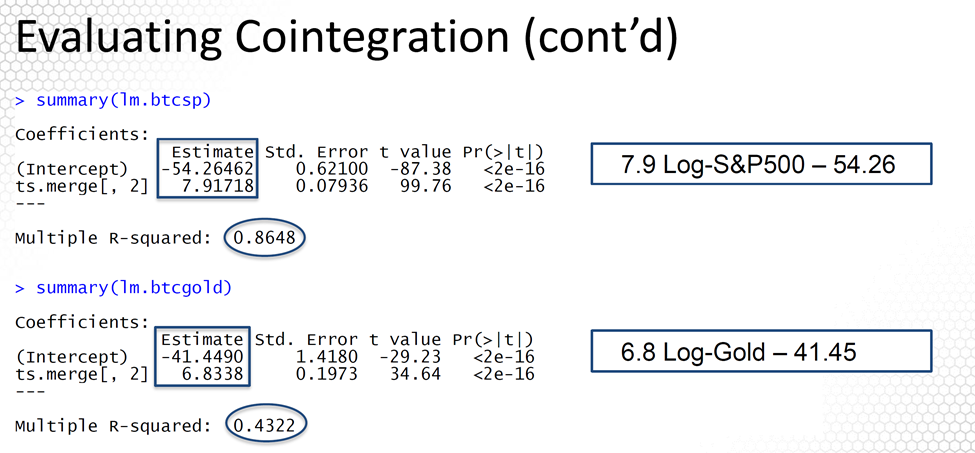

Let’s look at the regression outputs. 
- The first regression output is for log S&P500 price as a regressor and the second is for log gold price as a regressor. 
- The estimated coefficients give us the linear transformation such that we will derive plausible co-integrated times series. 

The resulting linear transformations used to compare to log-BTC are provided by the coefficients. In the next slide, I will compare the log-BTC price along with these transformations to evaluate co-integration graphically. Please note that simply applying the regression and forming the linear relationships will no guarantee co-integration. Later in this lesson, we will apply various methods to evaluate whether indeed the Log-BTC and Log-S&P500 or log-Gold are indeed co-integrated time series.

Last, I will highlight that the **R squared is quite large for the first regression but not as high for the second regression. Hence, it is possible for Bitcoin and S&P500 to be co-integrated but not for Bitcoin and gold.**

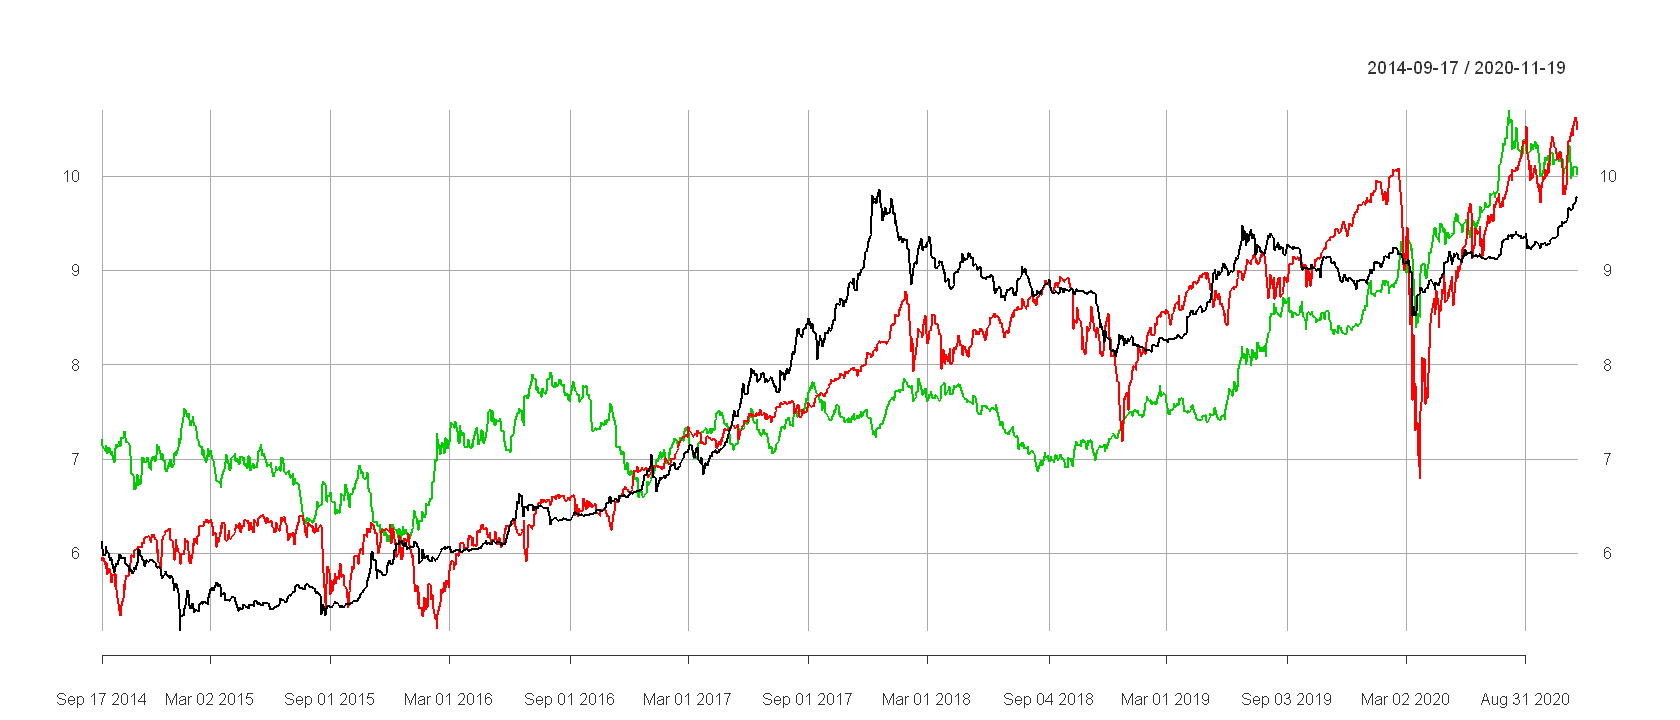

In [26]:
# # Plot all time series
ts.merge <- merge(tsbtc,tr.tssp, join='inner')
ts.merge <- merge(ts.merge,tr.tsgold, join='inner')
plot(ts.merge, main="")

- Those are the corresponding plots for the log-Bitcoin price in black, the linear transformed log S&P500 price in red and the linear transformed log gold price in green. 
- The insights provided by the R squared in the previous slide are confirmed here also. 
- While there are clear co-movements and similarities in the behavior of the Bitcoin price and S&P500 price, we don’t see such similarities for the Bitcoin and gold. 

I will continue the evaluation of co-integration for Bitcoin and S&P500 only.

**Testing for Cointegration**

In [27]:
## Evaluate potential cointegration between BTC & SP500
ts.merge <- merge(tsbtc,tr.tssp, join='inner')
co.resid <- ts.merge[,1]-ts.merge[,2]
adf.test(co.resid)


	Augmented Dickey-Fuller Test

data:  co.resid
Dickey-Fuller = -3.0475, Lag order = 11, p-value = 0.1349
alternative hypothesis: stationary


- Here I applied the **Engle-Granger Augmented Dickey-Fuller Test for cointegration**. 
- Specifically, in the context of our problem, we don’t have the exact coefficients for the co-integrated vector. 
- Those are provided by the regression where the response is the log Bitcoin and the regressor is the log S&P500 as also provided on the slide. 
- Further, I applied the Augmented Dickey-Fuller Test to this linear combination between the two time series to evaluate whether it is stationary. 
- **If it is not stationary then we conclude that the two time series are not co-integrated. The null hypothesis in the ADF test is that the time series provided by the linear combination of the two time series is not stationary.** 

The R output is on the slide. 

- The p-value of the test is 0.13, indicating that the time series is plausibly not stationary since we do not reject the null hypothesis. 
- More specifically, it is plausibly that the Bitcoin and S&P500 are not co-integrated according to this test.

**Testing for Cointegration using more sophisticated test from the library urca. The command is ur.df()**

- However, the test provided in the previous slide does not capture trend-stationarity or drift stationarity. 
- For example, trend stationarity would mean that after trend removal, the time series is stationary. 
- To do so, we can use a more sophisticated test for co-integration from the library urca. The command is ur.df(). 
- As implemented on the slide, we can apply this command to the time series, specifically, the linear combination of log Bitcoin price and log S&P500 price presented in the previous slide. 
- But this time we can specify whether to include “none”, meaning no trend or drift. This will be similar to the test provided in the previous slide. 
- We can also specify trend of drift as in the last command lines. The outputs will look different for each type. 
- In the next two slides, I will present the output from specifying drift or trend. 
- The results based on the type=none are the same as in the previous slide; we would not reject the null of non-stationarity hence not co-integrated.

In [28]:
library(urca)
summary(ur.df(co.resid, type="none",selectlags="BIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59707 -0.05167 -0.00487  0.04221  0.82794 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -0.01356    0.00456  -2.973    0.003 ** 
z.diff.lag -0.14036    0.02512  -5.587 2.72e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09596 on 1554 degrees of freedom
Multiple R-squared:  0.02727,	Adjusted R-squared:  0.02601 
F-statistic: 21.78 on 2 and 1554 DF,  p-value: 4.695e-10


Value of test-statistic is: -2.9729 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


**Testing for Cointegration with Drift**

In [29]:
summary(ur.df(co.resid, type="drift",selectlags="BIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59648 -0.05110 -0.00429  0.04280  0.82850 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0005812  0.0024335  -0.239  0.81127    
z.lag.1     -0.0135560  0.0045616  -2.972  0.00301 ** 
z.diff.lag  -0.1403985  0.0251297  -5.587 2.72e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09599 on 1553 degrees of freedom
Multiple R-squared:  0.02728,	Adjusted R-squared:  0.02602 
F-statistic: 21.77 on 2 and 1553 DF,  p-value: 4.723e-10


Value of test-statistic is: -2.9717 4.445 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.43 -2.86 -2.57
phi1  6.43  4.59  3.78


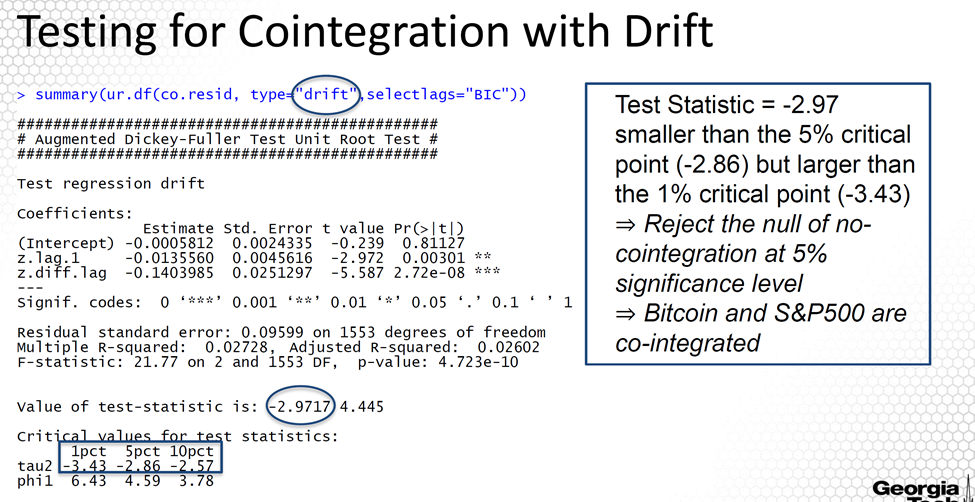


This is the output for testing for co-integration with drift, that is the alternative hypothesis is that after removing the drift in the time series, it will become stationary. Hence for co-integration, we would need to reject the null hypothesis. 

In order to decide whether or not to reject the null hypothesis, we compare the test statistic with the critical points. If the test statistic is smaller than the critical point, then we reject the null hypothesis. The output provides critical points for different significance levels, 1%, 5% and 10%. 

Based on this comparison, we find that test Statistic = -2.97 is smaller than the 5% critical point (equal to -2.86) but larger than the 1% critical point (equal to -3.43). This means that we reject the null of no-cointegration at 5% significance level but not at the level 1%. Hence, there is some evidence of co-integration after accounting for the drift.

**Testing for Cointegration with Trend**

In [30]:
summary(ur.df(co.resid, type="trend",selectlags="BIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59650 -0.05108 -0.00429  0.04280  0.82848 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.172e-04  4.896e-03  -0.126  0.89970    
z.lag.1     -1.356e-02  4.589e-03  -2.955  0.00317 ** 
tt           4.620e-08  5.450e-06   0.008  0.99324    
z.diff.lag  -1.404e-01  2.514e-02  -5.584 2.77e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09602 on 1552 degrees of freedom
Multiple R-squared:  0.02728,	Adjusted R-squared:  0.0254 
F-statistic: 14.51 on 3 and 1552 DF,  p-value: 2.543e-09


Value of test-statistic is: -2.9549 2.9614 4.4128 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.96 -3.

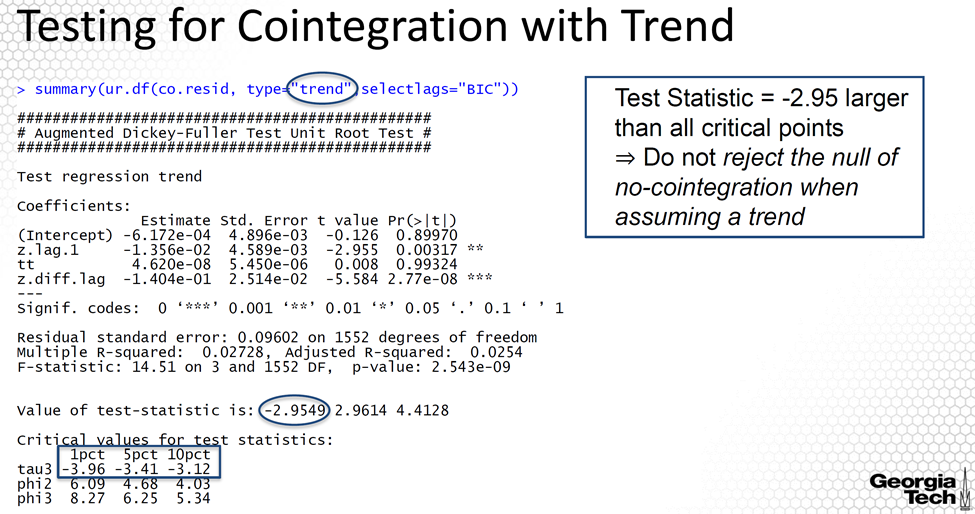


This is the output for testing for co-integration with linear trend, that is the alternative hypothesis is that after removing the trend in the time series, it will become stationary. Similarly to the previous tests, **for co-integration, we would need to reject the null hypothesis.**

In order to decide whether or not to reject the null hypothesis, we compare the test statistic with the critical points. If the test statistic is smaller than the critical point, then we reject the null hypothesis. 

Based on this comparison, we find that test Statistic = -2.95 is larger than all critical points, meaning that we do not reject the null of no-cointegration assuming a trend has been accounted for. Note that it is not unusual for the results to look different when comparing type = “none”, “drift” or “trend”.

**Fit VECM for BTC Price and S&P500**

- Next I am applying the VEC model for two time series, log Bitcoin price and log S&P500 price. 
- I am using here the dynlm() command. 
- For the first model equation, the response variable is the difference log Bitcoin price where the regressors are the first order difference of the difference time series for both log Bitcoin and log S&P500 price and the error correction term.

In [31]:
## Fit VECM 
library(dynlm)
tsbtc <-as.numeric(ts.merge[,1])
tssp <- as.numeric(ts.merge[,2])
## Set Error Correction Term
tsdif <- tsbtc[-1]-tssp[-1]

In [32]:
# Fit VECM for BTC Price
VECM_BTC <- dynlm(d(tsbtc) ~ L(d(tssp), 1) + L(d(tsbtc), 1) +  L(tsdif))
names(VECM_BTC$coefficients) <- c("Intercept", "D_SP_l1","D_BTC_l1", "ect_l1")
coeftest(VECM_BTC, vcov. = NeweyWest(VECM_BTC, prewhite = F, adjust = T))

Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"



t test of coefficients:

             Estimate  Std. Error     t value  Pr(>|t|)    
Intercept  1.6245e-18  4.8898e-19  3.3223e+00 0.0009135 ***
D_SP_l1    4.5339e-17  4.5351e-18  9.9973e+00 < 2.2e-16 ***
D_BTC_l1   1.0000e+00  7.1608e-18  1.3965e+17 < 2.2e-16 ***
ect_l1    -1.1655e-20  1.9534e-19 -5.9700e-02 0.9524305    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


The output for the equation corresponding to Bitcoin Price is on the slide. 

- The output consists of the estimated coefficients and inference on their statistical significance. 
- For this model, we note a warning saying that the statistical inference is not reliable because this seems like a perfect fit. - This is seen in the estimated coefficients. 
- The lagged $\mathrm{\Delta SP}500$ has a very small coefficient whereas the Lagged $\mathrm{\Delta BTC}$ has a coefficient equal to 1. 
- **The error correction term is not statistically significant. This means that the model does not capture the co-integration**. 
- If you recall, we had co-integration with a drift. This model has not accounted for the drift, specifically the error correction term is not correctly modeled. 
- There are various other more advance modeling techniques that can be used to deal with trend and drift. 
- Moreover, finding the number of lags for the VEC model also needs to be considered.

In [33]:
# Fit VECM for S&P500 Price
VECM_SP <- dynlm(d(tssp) ~ L(d(tssp), 1) + L(d(tsbtc), 1) +  L(tsdif))
names(VECM_SP$coefficients) <- c("Intercept", "D_SP_l1","D_BTC_l1", "ect_l1")
coeftest(VECM_SP, vcov. = NeweyWest(VECM_SP, prewhite = F, adjust = T))

Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"



t test of coefficients:

             Estimate  Std. Error     t value Pr(>|t|)    
Intercept  1.0551e-18  6.9121e-19  1.5265e+00   0.1271    
D_SP_l1    1.0000e+00  4.3774e-18  2.2845e+17   <2e-16 ***
D_BTC_l1  -2.3955e-17  2.3270e-17 -1.0294e+00   0.3034    
ect_l1     5.0928e-19  4.6888e-19  1.0862e+00   0.2776    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


**End**